In [28]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [29]:
# Parámetros
sourceDataFolder = "1-source-data"

emailsRootPath = sourceDataFolder + r"\support\email"
covidRootPath = sourceDataFolder + r"\support\covid"
gysAdRootPath = sourceDataFolder + r"\support\gys-ad"
azureAdRootPath = sourceDataFolder + r"\support\azure-ad"
inHomeRootPath = sourceDataFolder + r"\support\in-home"
mainRootPath = sourceDataFolder + r"\main"
supportRootPath = sourceDataFolder + r"\support"
mastersRootPath = sourceDataFolder + r"\masters"

intermFilesFolder = "2-intermediate-files"
mastersFolder = intermFilesFolder + r"\masters"

resultsFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [30]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readSupport(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(intermFilesFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

In [31]:
def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        #print(str(soup))
        # El soup.text le quita las etiquetas
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          allAttendees = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          attendeesList = allAttendees.split("; ")
          attendees.extend(attendeesList)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(intermFilesFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

In [32]:
def readAndWriteTaggedData(preprocessedData, emailsData, covidData, gysAdData, azureAdData, inHomeData):
  # Definiendo arrays con el nombre
  arrayNames = [
    getCompare(emailsData, ["nombreParaMostrar"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["nombreParaMostrar"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(gysAdData, ["Nombre para mostrar"]),
    getCompare(gysAdData, ["Nombre", "Apellido"]),
    getCompare(azureAdData, ["displayName"]),
    getCompare(azureAdData, ["givenName", "surname"]),
    getCompare(inHomeData, ["name"]),
  ]

  # Leyendo la data de contratados
  sensitivity = 0.84

  for index, row in enumerate(preprocessedData):
    if (index % 100 == 0):
      print(str(index) + "/" + str(len(preprocessedData)) + " registros analizados")
    for arrayName in arrayNames:
      for elem in arrayName:
        distance = jellyfish.jaro_distance(row["candidateName"], elem)
        if (distance >= sensitivity):
          row["hired"] = 1
          break
      if "hired" not in row:
        row["hired"] = 0
  
  writeJson(preprocessedData, os.path.join(intermFilesFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(intermFilesFolder, 'result.csv'), 'utf-8')

  return preprocessedData


In [33]:
def readAndWritePreprocessedData(mergedMainData, masters):
  # Añadiendo los nuevos campos del puesto de trabajo
  for elem in mergedMainData:
    for elem2 in masters[0]:
      if elem["profileName"] == elem2["profileName"]:
        elem["profileName"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[1]:
      if elem["lastWorkCenter"] == elem2["lastWorkCenter"]:
        elem["lastWorkCenter"] = elem2["equivalence"]

  # Añadiendo los nuevos campos de la ultima posición
  for elem in mergedMainData:
    for elem2 in masters[2]:
      if elem["lastWorkPosition"] == elem2["lastWorkPosition"]:
        elem["lastWorkPosition"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[3]:
      if elem["studyCenter"] == elem2["studyCenter"]:
        elem["studyCenter"] = elem2["equivalence"]

  writeJson(mergedMainData, os.path.join(resultsFolder, 'result.json'), 'utf-8')
  writeCsv(mergedMainData, os.path.join(resultsFolder, 'result.csv'), 'utf-8')

  return mergedMainData

In [34]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.info())

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["postulationDate", "candidateName"]] 

  for column in columns:
    groupedData = df[column].value_counts()
    print("Total de valores diferentes: " + str(len(groupedData)))
    top10 = groupedData[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [35]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # Leyendo la data obtenida en el entendimiento de los datos
  mergedMainData = readJson(os.path.join(mainRootPath, 'result.json'))

  # Definiendo variables booleanas para leer o leer y procesar los archivos de apoyo
  isLoadedEmailData = True
  isLoadedCovidData = True
  isLoadedGysAdData = True
  isLoadedAzureAdData = True
  isLoadedInHomeData = True
  isTaggedData = True
  isPreprocessed = False

  # Leyendo el archivo de correos
  emailsData = readJson(os.path.join(intermFilesFolder, 'email.json')) if isLoadedEmailData else readAndWriteSupport(emailsRootPath, 'email.csv', 'email.json', 'windows-1252')
  print("Se terminó de procesar email")

  # Leyendo el archivo de covid
  covidData = readJson(os.path.join(intermFilesFolder, 'covid.json')) if isLoadedCovidData else readAndWriteSupport(covidRootPath, 'covid.csv', 'covid.json', 'windows-1252')
  print("Se terminó de procesar covid")

  # Leyendo el archivo de gys AD
  gysAdData = readJson(os.path.join(intermFilesFolder, 'gys-ad.json')) if isLoadedGysAdData else readAndWriteSupport(gysAdRootPath, 'gys-ad.csv', 'gys-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar gysAd")

  # Leyendo el archivo de azure AD
  azureAdData = readJson(os.path.join(intermFilesFolder, 'azure-ad.json')) if isLoadedAzureAdData else readAndWriteSupport(azureAdRootPath, 'azure-ad.csv', 'azure-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar azureAd")

  # Leyendo el archivo de inHome
  inHomeData = readJson(os.path.join(intermFilesFolder, 'in-home.json')) if isLoadedInHomeData else readAndWriteInHome(inHomeRootPath, 'in-home.json')
  print("Se terminó de procesar inHome")

  # Asignando la variable objetivo
  taggedData = readJson(os.path.join(intermFilesFolder, 'result.json')) if isTaggedData else readAndWriteTaggedData(mergedMainData, emailsData, covidData, gysAdData, azureAdData, inHomeData)
  print("Se terminó de procesar la data final")

  # Preprocesamiento de datos
  # Leyendo archivos maestros
  profileNameMaster = readSupport(os.path.join(mastersRootPath, 'profileName.csv'))
  lastWorkCenterMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkCenter.csv'))
  lastWorkPositionMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkPosition.csv'))
  studyCenterMasterMaster = readSupport(os.path.join(mastersRootPath, 'studyCenter.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(resultsFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(taggedData, [profileNameMaster, lastWorkCenterMaster, lastWorkPositionMaster, studyCenterMasterMaster])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-13 04:03:26.312973
Se inició el procesamiento
Se terminó de procesar email
Se terminó de procesar covid
Se terminó de procesar gysAd
Se terminó de procesar azureAd
Se terminó de procesar inHome
Se terminó de procesar la data final
Se terminó el preprocesamiento
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   postulationDate    6216 non-null   object
 1   profileName        6216 non-null   object
 2   candidateName      6216 non-null   object
 3   residenceCountry   6216 non-null   object
 4   lastWorkCenter     6216 non-null   object
 5   lastWorkPosition   6216 non-null   object
 6   yearsOfExperience  6216 non-null   int64 
 7   worksNumber        6216 non-null   int64 
 8   studyCenter        6216 non-null   object
 9   careerField        6216 non-null   object
 10  careerStatus       6216 non-null   object
 11 

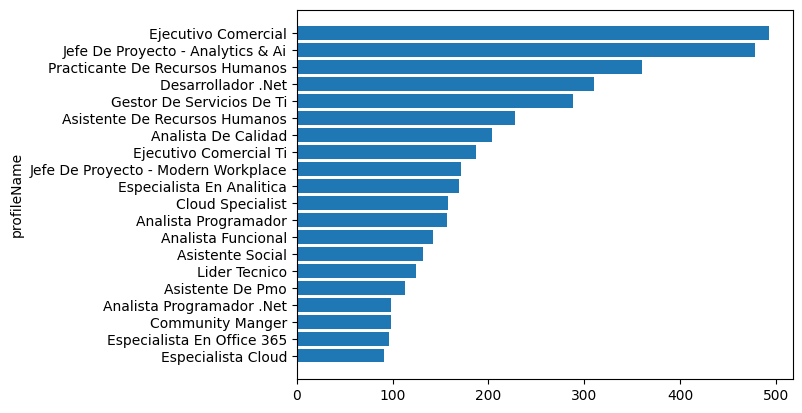

Total de valores diferentes: 11
Peru                    6085
Venezuela                109
Argentina                  9
Brasil                     3
Colombia                   3
Ecuador                    2
El Salvador                1
Panama                     1
Republica Dominicana       1
Francia                    1
Bolivia                    1
Name: residenceCountry, dtype: int64


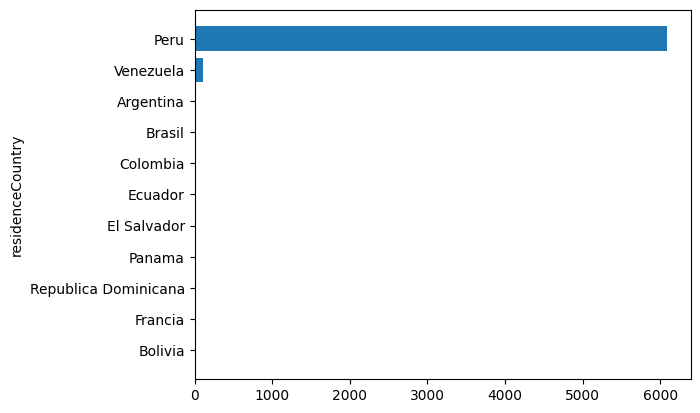

Total de valores diferentes: 2781
Freelance                                          168
Ntt Data Peru S.A.C.                               123
Canvia S.A.C.                                       95
Manpower Professional Services S.A.                 86
Mdp Consulting S.A.C.                               78
Global Hitss Peru S.A.C.                            68
Indra Peru S.A.                                     66
Telefonica Del Peru                                 57
Banco De Credito Del Peru - Bcp                     46
Stefanini It Solutions                              35
Tata Consultancy Services                           34
Corporacion Sapia S.A.                              34
Gfi Peru Sac                                        33
Universidad Peruana De Ciencias Aplicadas (Upc)     32
America Movil Peru S.A.C.                           27
Tivit Latam                                         26
Tgestiona Sac                                       25
Ibm Del Peru S.A.C.            

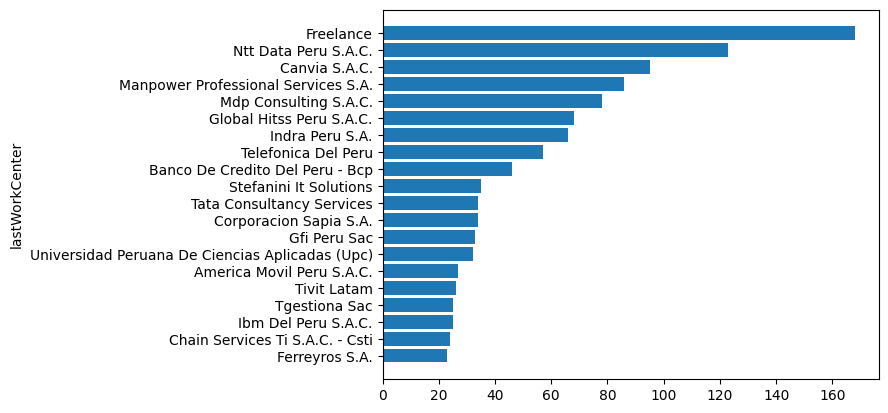

Total de valores diferentes: 2569
Analista Programador                            342
Analista De Sistemas                            139
Jefe De Proyectos                               138
Analista Funcional                              106
Supervisor De Infraestructura De Redes Cisco     84
Analista De Calidad                              80
Project Manager                                  66
Ejecutivo Comercial                              52
Asistente Administrativo                         50
Asistente De Recursos Humanos                    50
Trabajadora Social                               47
Lider Tecnico                                    46
Gerente De Proyectos                             42
Analista Desarrollador                           40
Analista                                         39
Jefe De Sistemas                                 38
Soporte Tecnico                                  37
Gestor De Proyectos                              35
Asesor Comercial              

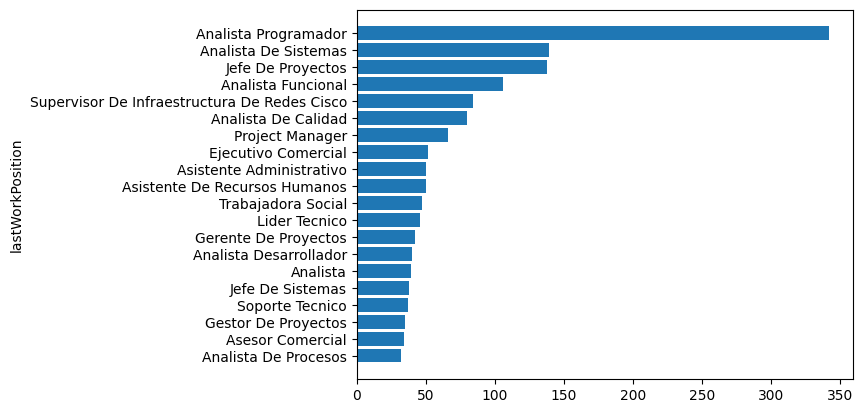

Total de valores diferentes: 53
5     490
4     475
8     456
6     450
7     418
2     374
9     373
3     357
10    351
1     315
11    291
0     246
13    215
12    210
15    202
14    179
16    129
17     97
18     89
19     84
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


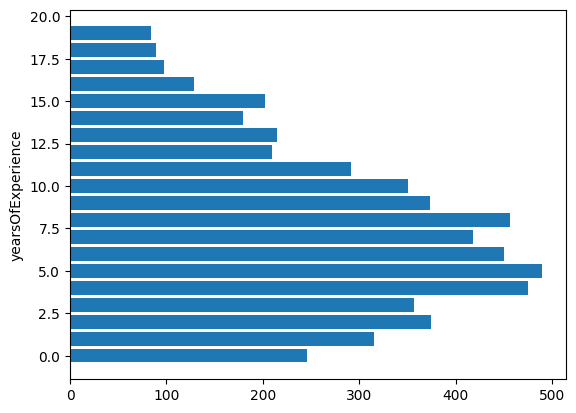

Total de valores diferentes: 25
5     855
6     769
4     752
7     674
3     546
8     512
9     385
2     369
10    322
1     222
11    207
12    202
13    118
14    105
15     61
17     29
16     28
18     17
19     12
21      8
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


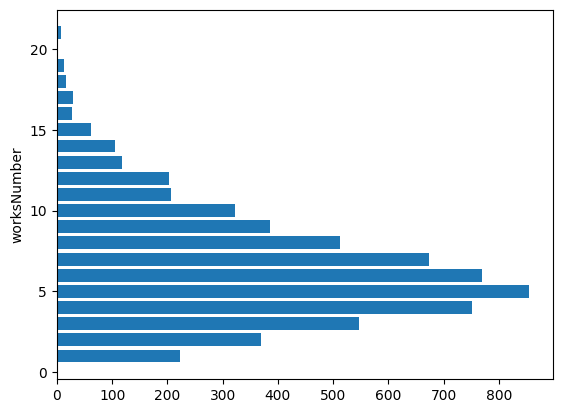

Total de valores diferentes: 939
Universidad Peruana De Ciencias Aplicadas    517
Universidad Tecnologica Del Peru             304
Instituto Cibertec                           243
Pontificia Universidad Catolica Del Peru     216
Universidad San Ignacio Del Loyola           206
Universidad Esan                             203
Universidad Nacional Mayor De San Marcos     187
Universidad Privada Del Norte                169
Universidad Cesar Vallejo                    157
Universidad Nacional De Ingenieria           140
Universidad Ricardo Palma                    125
Universidad De Lima                          121
Universidad Nacional Federico Villarreal     110
Universidad De San Martin De Porres          106
Instituto San Ignacio De Loyola              106
Universidad Inca Garcilaso De La Vega         94
Tecsup                                        91
Universidad Del Pacifico                      79
Instituto Superior Tecnologico Idat           71
Universidad Alas Peruanas           

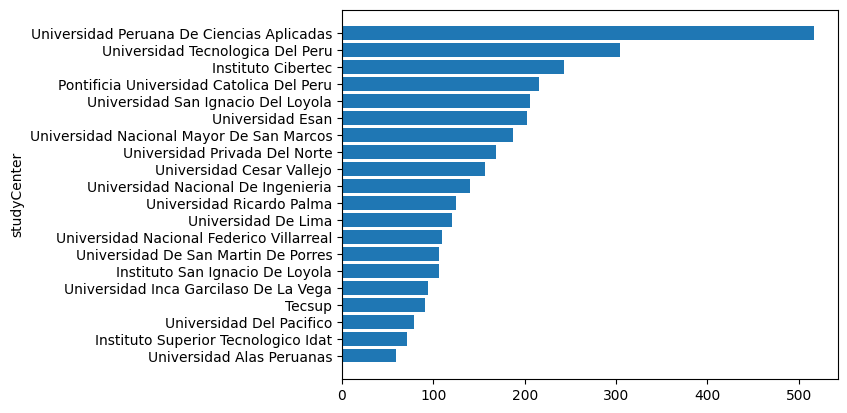

Total de valores diferentes: 95
Ing. En Sistemas                  1450
Tecnologias De La Informacion      953
Adm. De Empresas                   645
Ing. Informatica                   373
Ing. Industrial                    308
Computacion / Informatica          263
Otra                               247
Marketing / Comercializacion       238
Recursos Humanos / Relac. Ind.     206
Ing. - Otros                       125
Psicologia                         114
Telecomunicaciones                  90
Ing. Telecomunicaciones             87
Analisis De Sistemas                84
Procesos / Calidad Total            78
Programacion                        74
Trabajo Social                      65
Finanzas                            64
Ing. Electronica                    58
Bachiller                           53
Name: careerField, dtype: int64


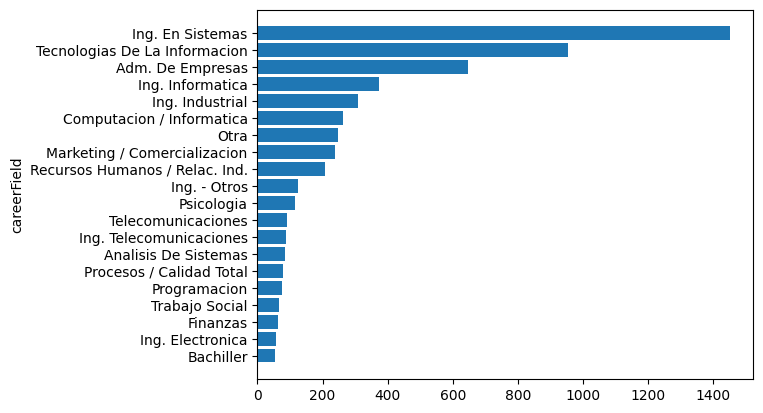

Total de valores diferentes: 3
Graduado      4381
En Curso      1761
Abandonado      74
Name: careerStatus, dtype: int64


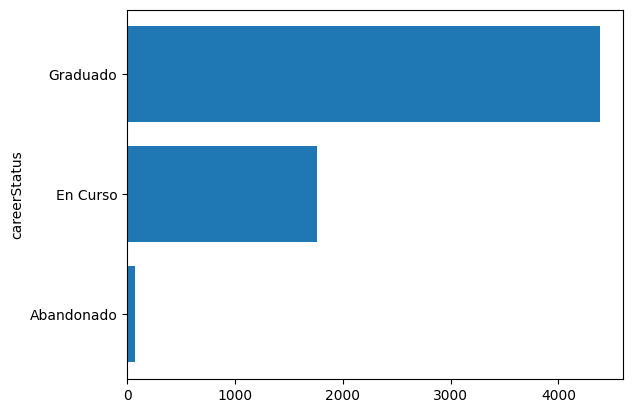

Total de valores diferentes: 7
Universitario        2729
Otro                 1624
Posgrado              888
Terciario/Tecnico     509
Master                450
Doctorado              13
Secundario              3
Name: careerDegree, dtype: int64


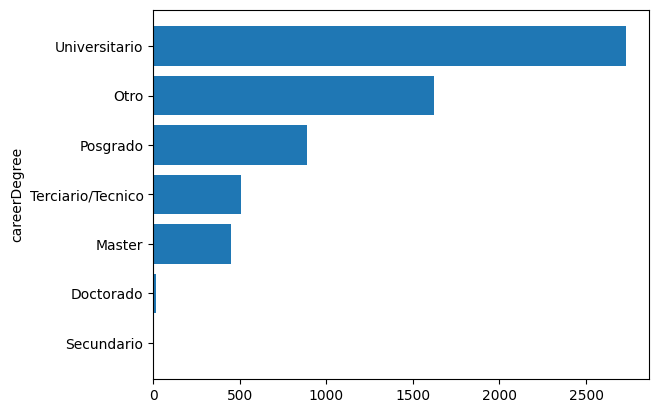

Total de valores diferentes: 36
1     1858
2     1414
3      827
4      499
6      335
5      322
7      240
8      149
9      116
11      86
10      80
12      61
14      45
13      36
16      23
15      19
20      18
18      16
17      14
19      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


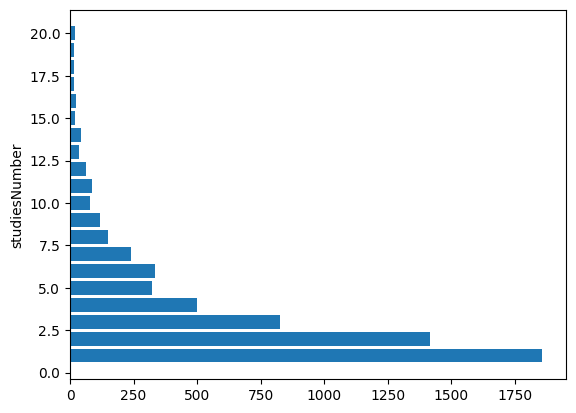

Total de valores diferentes: 64
1     664
3     543
2     495
4     429
5     410
6     350
7     336
9     335
8     315
10    255
11    246
13    197
12    197
16    185
14    134
15    113
18     95
17     93
21     77
19     68
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


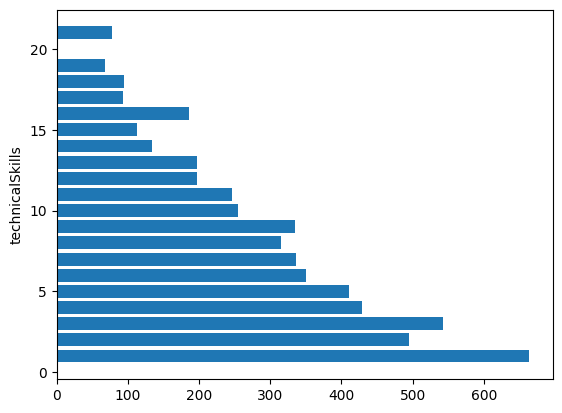

Total de valores diferentes: 6
1    4656
2    1288
3     197
4      51
0      23
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


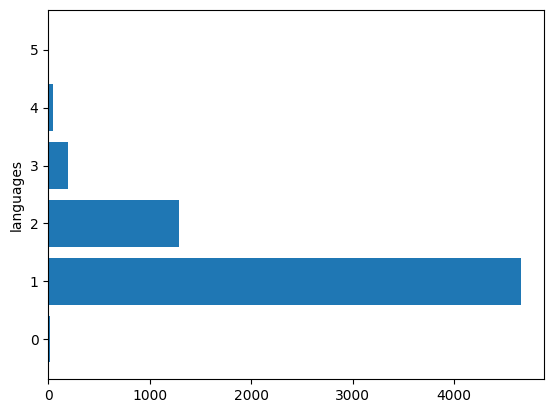

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


Total de valores diferentes: 43
1     1288
2      904
3      650
4      593
5      536
6      405
7      353
8      291
9      223
10     182
11     147
12     117
13      93
14      69
15      64
17      42
16      35
20      31
19      25
23      22
Name: anotherSkills, dtype: int64


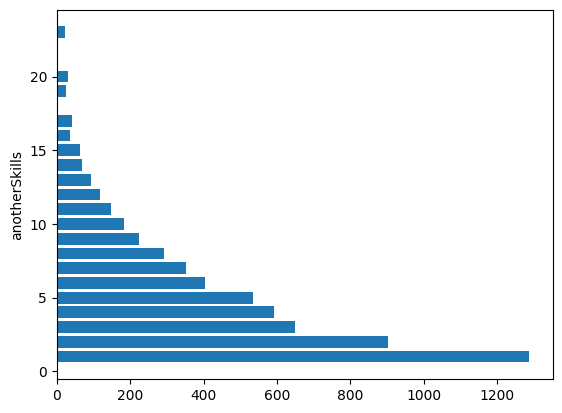

Total de valores diferentes: 152
5000     413
2500     391
3500     381
3000     370
4000     369
2000     351
6000     347
4500     291
1500     247
1800     238
5500     220
6500     205
7000     200
1200     158
8000     154
1000     125
1        119
7500     110
10000    102
1025     101
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_19796\1076635595.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


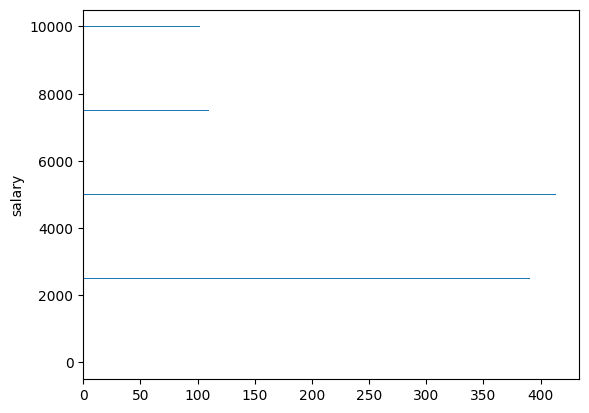

Total de valores diferentes: 2
0    5812
1     404
Name: hired, dtype: int64


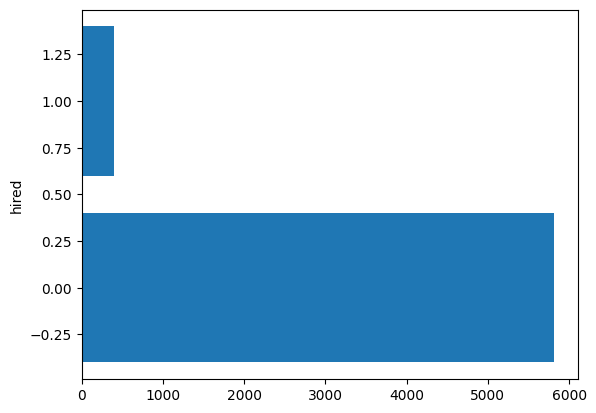

Fin: 2023-05-13 04:03:29.690055
Tiempo: 0:00:03.377082


In [36]:
if __name__ == "__main__":
  main()